# Pemisahan katalog berdasarkan sumber gempa

Jalankan file ini di Openquake yang sudah diinstal di komputer masing-masing.

atau:

Jalankan file ini di jupyter dengan cara mengubah kernel ke `openquake`. Jika kernel `openquake` belum ada, lakukan langkah-langkah berikut ini:

Openquake dapat diunduh di sini:
https://downloads.openquake.org/pkgs/windows/oq-engine/OpenQuake_Engine_3.11.5-1.exe

Install beberapa tambahan packages di openquake:

(Asumsi lokasi instalasi openquake di sini: `C:\Program Files\Openquake Engine\python3.6\`, 
jika tidak maka ubah lokasi tersebut sesuai dengan komputer masing-masing)

1. Buka Command Prompt
2. Install `jupyter`: `"C:\Program Files\Openquake Engine\python3.6\python.exe" -m pip install jupyter`
3. Daftarkan ke dalam kernel (opsional): `"C:\Program Files\Openquake Engine\python3.6\python.exe" -m ipykernel install --name "openquake" --display-name "openquake"`


Untuk uji coba, jalankan salah satu baris di bawah ini:

`"C:\Program Files\Openquake Engine\python3.6\Scripts\jupyter.exe" notebook`

atau

`"C:\Program Files\Openquake Engine\python3.6\Scripts\jupyter-notebook.exe"`

## 1. Import packages

Hal ini memastikan apakah python yang digunakan sudah menyediakan packages yang dibutuhkan.

In [1]:
from custom_openquake import *
import warnings
warnings.filterwarnings('ignore')

# folder penyimpanan
dir_figs = os.path.join(os.getcwd(), 'figs')
os.makedirs(dir_figs, exist_ok=True)

## 3. Katalog gempa (declustered)

In [2]:
# membuka data pkl
catalogue_declustered = open_pkl('tmp_OQ002_catalogue_declustered.pkl')

## 4. Patahan

### 4.1 Memisahkan katalog berdasarkan area patahan

In [3]:
# membuka data pkl
fault_geoms = open_pkl('tmp_OQ003_fault_geoms.pkl')
dict_faults = open_pkl('dict_faults.pkl')

# membuat area dari patahan
area_faults, area_faults_geoms = create_area_faults(fault_geoms, distance=20)

# memisahkan katalog berdasarkan area patahan
catalogue_area_faults = create_catalogue_from_area_faults(catalogue_declustered, area_faults, 
                                                          dict_faults=dict_faults)

# menyimpan data katalog (cek dengan nama file "dict_catalogue_fault_xxx.pkl")
catalogue_to_pkl(catalogue_area_faults, dict_faults=dict_faults, type_of="fault")

# simpan variabel untuk dipakai di tahapan berikutnya
variable_to_pkl(catalogue_area_faults, "tmp_OQ004_catalogue_area_faults.pkl")
variable_to_pkl(area_faults_geoms, "tmp_OQ004_area_faults_geoms.pkl")

### 4.2 Menampilkan distribusi katalog

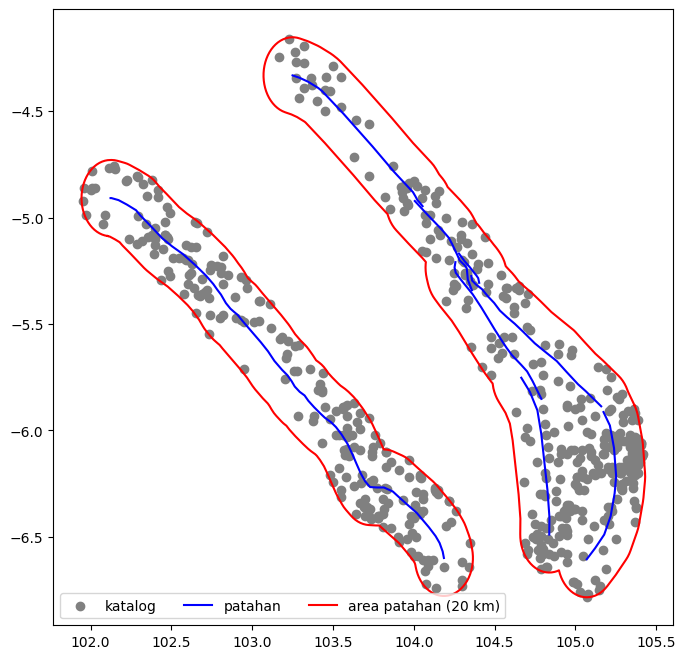

In [4]:
# melihat distribusi data pada gambar

list_variables = (
    catalogue_area_faults,
    fault_geoms,
    area_faults
)
list_colors = (
    ['grey','none'],
    ['b','none'],
    ['r','none']
)
list_labels = (
    "katalog",
    "patahan",
    "area patahan (20 km)"
)

fig, _ = quick_create_maps(list_variables, list_colors, list_labels, figsize=(8,8))

## 5. Megathrust

### 5.1 Memisahkan katalog berdasarkan area megathrust

In [5]:
# membuka data pkl
megathrust_geoms = open_pkl("tmp_OQ003_megathrust_geoms.pkl")

# memisahkan katalog berdasarkan area megathrust
catalogue_megathrusts = create_catalogue_megathrusts(catalogue_declustered, megathrust_geoms, distance = 20)

# simpan data katalog (cek dengan nama file "dict_catalogue_megathrust_xxx.pkl")
catalogue_to_pkl(catalogue_megathrusts, type_of="megathrust")

# simpan variabel untuk dipakai di tahapan berikutnya
variable_to_pkl(catalogue_megathrusts, "tmp_OQ004_catalogue_megathrusts.pkl")

### 5.2 Menampilkan distribusi katalog

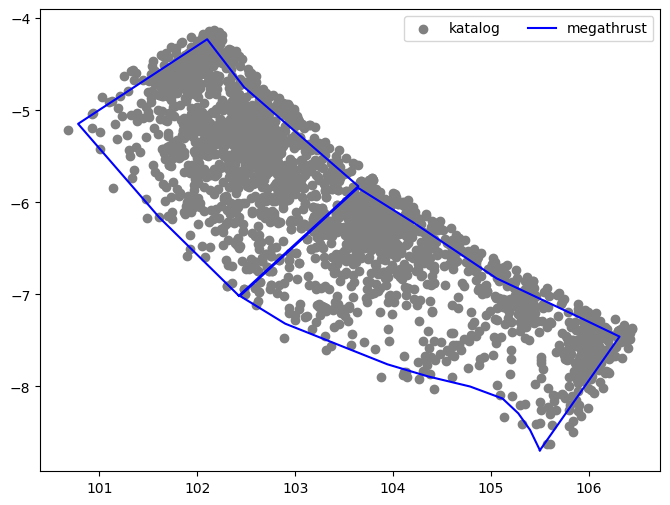

In [6]:
# melihat distribusi data pada gambar

list_variables = (
    catalogue_megathrusts,
    megathrust_geoms
)
list_colors = (
    ['grey','none'],
    ['b','none']
)
list_labels = (
    "katalog",
    "megathrust"
)

fig, _ = quick_create_maps(list_variables, list_colors, list_labels, figsize=(8,6))

## 6. Shallow Background

### 6.1 Memisahkan katalog berdasarkan area shallow background

In [7]:
# membuka data pkl
shallow_background_geoms = open_pkl("tmp_OQ003_shallow_background_geoms.pkl")

# memisahkan data katalog berdasarkan area background
catalogue_shallow_backgrounds = create_catalogue_from_shallow_backgrounds(
    catalogue_declustered, shallow_background_geoms, lower_depth=20
)

# menyimpan data katalog  (cek dengan nama file "dict_catalogue_shallow_background_xxx.pkl")
catalogue_to_pkl(catalogue_shallow_backgrounds, type_of="shallow background")

# simpan variabel untuk dipakai di tahapan berikutnya
variable_to_pkl(catalogue_shallow_backgrounds, "tmp_OQ004_catalogue_shallow_backgrounds.pkl")

### 6.2 Menampilkan distribusi katalog

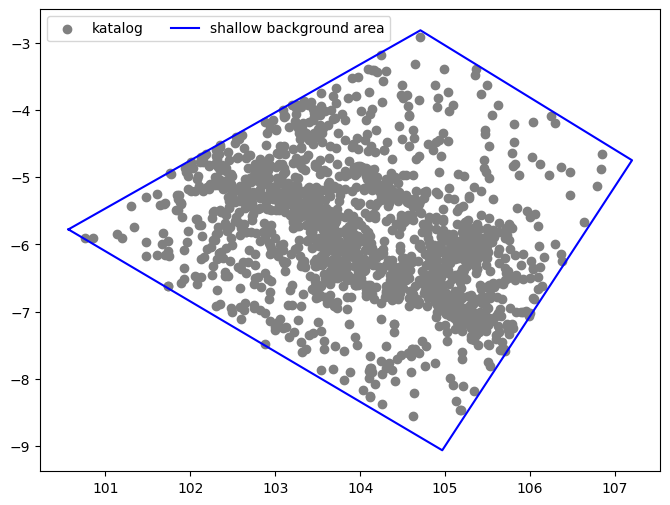

In [8]:
# melihat distribusi data pada gambar
list_variables = (
    catalogue_shallow_backgrounds,
    shallow_background_geoms
)
list_colors = (
    ['grey','none'],
    ['b','none']
)
list_labels = (
    "katalog",
    "shallow background area"
)

fig, _ = quick_create_maps(list_variables, list_colors, list_labels, figsize=(8,6))

## 7. Deep Background (intraslab)

### 7.1 Memisahkan katalog berdasarkan area deep background

In [9]:
# membuka data pkl
deep_background_geoms = open_pkl("tmp_OQ003_deep_background_geoms.pkl")

# memisahkan data katalog berdasarkan area background
catalogue_deep_backgrounds, range_list = create_catalogue_from_deep_backgrounds(
    catalogue_declustered, deep_background_geoms, upper_depth=350, increment=100, lower_depth=700
)

# menyimpan data katalog  (cek dengan nama file "dict_catalogue_deep_background_xxx.pkl")
catalogue_to_pkl(catalogue_deep_backgrounds, range_deep=range_list, type_of="deep background")

# simpan variabel untuk dipakai di tahapan berikutnya
variable_to_pkl((catalogue_deep_backgrounds, range_list), "tmp_OQ004_catalogue_deep_backgrounds.pkl")

### 7.2 Menampilkan distribusi katalog

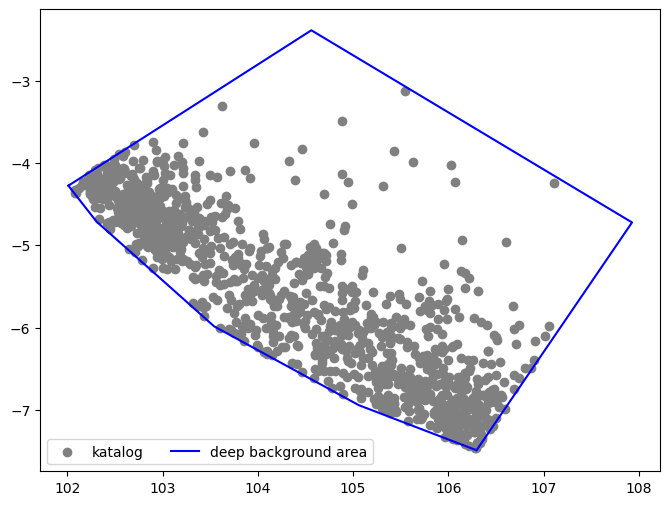

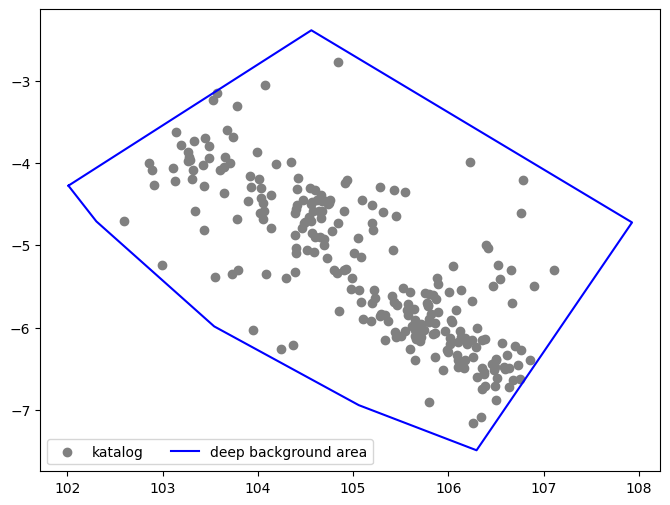

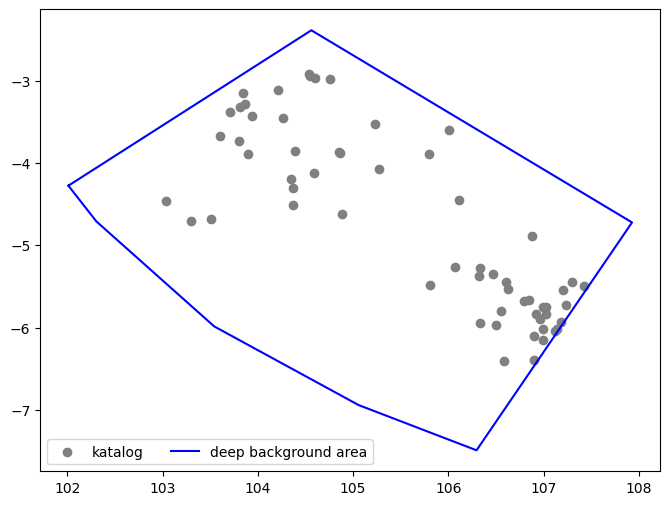

In [10]:
# melihat distribusi data pada gambar

for list_cat in catalogue_deep_backgrounds:
    for cat in list_cat:
        list_variables = (
            cat,
            deep_background_geoms
        )
        list_colors = (
            ['grey','none'],
            ['b','none']
        )
        list_labels = (
            "katalog",
            "deep background area"
        )

        fig, _ = quick_create_maps(list_variables, list_colors, list_labels, figsize=(8,6))